<a href="https://colab.research.google.com/github/FedyaBadyilo/review_classification/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!tar -xzvf '/content/drive/MyDrive/greenatom_test_task/aclImdb_v1.tar.gz'

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/pos/9935_7.txt
aclImdb/train/pos/9934_8.txt
aclImdb/train/pos/9933_8.txt
aclImdb/train/pos/9932_8.txt
aclImdb/train/pos/9931_9.txt
aclImdb/train/pos/9930_8.txt
aclImdb/train/pos/9929_7.txt
aclImdb/train/pos/9928_7.txt
aclImdb/train/pos/9927_9.txt
aclImdb/train/pos/9926_7.txt
aclImdb/train/pos/9925_7.txt
aclImdb/train/pos/9924_9.txt
aclImdb/train/pos/9923_7.txt
aclImdb/train/pos/9922_10.txt
aclImdb/train/pos/9921_8.txt
aclImdb/train/pos/9920_7.txt
aclImdb/train/pos/9919_9.txt
aclImdb/train/pos/9918_10.txt
aclImdb/train/pos/9917_10.txt
aclImdb/train/pos/9916_7.txt
aclImdb/train/pos/9915_8.txt
aclImdb/train/pos/9914_7.txt
aclImdb/train/pos/9913_10.txt
aclImdb/train/pos/9912_10.txt
aclImdb/train/pos/9911_10.txt
aclImdb/train/pos/9910_10.txt
aclImdb/train/pos/9909_7.txt
aclImdb/train/pos/9908_8.txt
aclImdb/train/pos/9907_7.txt
aclImdb/train/pos/9906_10.txt
aclImdb/train/pos/9905_10.txt
aclImdb/train/pos/9904_8

In [13]:
import warnings
import os
import re

import seaborn as sns
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, auc, f1_score, explained_variance_score, roc_curve, classification_report, mean_absolute_error, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText
from gensim.models.callbacks import CallbackAny2Vec
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification, get_scheduler, AdamW, get_cosine_with_hard_restarts_schedule_with_warmup

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# data import

напишем функцию для извечения тренировочных и тествых данных

In [ ]:
def extract_data(root_dir):
  labels = ['pos', 'neg']

  data_dct = {
    'id': [],
    'text': [],
    'rating': [],
    'label': [],
    }

  for label in labels:
      dir_path = os.path.join(root_dir, label)

      for filename in os.listdir(dir_path):
          file_path = os.path.join(dir_path, filename)
          rating_id_split = filename.split('.')[0].split('_')
          id, rating = rating_id_split

          with open(file_path, 'r', encoding='utf-8') as f:
              text = f.read()

          data_dct['text'].append(text)
          data_dct['label'].append(label)
          data_dct['rating'].append(int(rating))
          data_dct['id'].append(int(id))

  print('data was extracted succesful')

  return data_dct

In [ ]:
root_dir = '/content/aclImdb'

In [ ]:
train_data_dct = extract_data(root_dir + '/train')
test_data_dct = extract_data(root_dir + '/test')

data was extracted succesful
data was extracted succesful


# EDA


In [ ]:
df_train = pd.DataFrame(train_data_dct)
df_train.head()

,id,text,rating,label
0,8375,<br /><br />Robot jox is a great little film o...,8,pos
1,7309,"As I mentioned previously, John Carpenter's 19...",9,pos
2,1575,The van trotta movie rosenstrasse is the best ...,9,pos
3,816,"first, i'd like to say that, while i know my s...",10,pos
4,11287,As noted by other reviewers this is one of the...,8,pos


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  int64 
 1   text    25000 non-null  object
 2   rating  25000 non-null  int64 
 3   label   25000 non-null  object
dtypes: int64(2), object(2)
memory usage: 781.4+ KB


In [ ]:
df_train[['label']].value_counts(), df_train['rating'].value_counts()

(label
 neg      12500
 pos      12500
 Name: count, dtype: int64,
 rating
 1     5100
 10    4732
 8     3009
 4     2696
 7     2496
 3     2420
 2     2284
 9     2263
 Name: count, dtype: int64)

In [ ]:
df_test = pd.DataFrame(test_data_dct)
df_test.head()

,id,text,rating,label
0,12195,Although this movie doesn't have the darkness ...,10,pos
1,8375,Its a good film set in Vienna about a cab driv...,8,pos
2,2286,*Minor spoilers* I just wanted to say that for...,9,pos
3,46,I have watch this movie almost every night tha...,10,pos
4,7734,I just cannot believe the low scores for this ...,10,pos


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  int64 
 1   text    25000 non-null  object
 2   rating  25000 non-null  int64 
 3   label   25000 non-null  object
dtypes: int64(2), object(2)
memory usage: 781.4+ KB


In [ ]:
df_test[['label']].value_counts(), df_test['rating'].value_counts()

(label
 neg      12500
 pos      12500
 Name: count, dtype: int64,
 rating
 1     5022
 10    4999
 8     2850
 4     2635
 3     2541
 9     2344
 7     2307
 2     2302
 Name: count, dtype: int64)

# Code clean up

отчистим тексты от ненужных символов

In [ ]:
def clean_review(review, remove_stopwords=False):
    review = BeautifulSoup(review, "lxml").get_text()
    review = re.sub("@[A-Za-z0-9_]+","", review)

    review = re.sub("https?://[^ ]+","",review)
    review = re.sub("www.[^ ]+","",review)

    try:
        review = review.decode("utf-8-sig")
    except:
        pass

    review.replace(u"\ufffd", "?")
    review = re.sub("[^a-zA-Z]"," ", review)
    words = WordPunctTokenizer().tokenize(review.lower())

    if remove_stopwords:
        words = [w for w in words if w not in set(stopwords.words("english"))]

    cleaned_review = (" ".join(words)).strip()

    return cleaned_review

In [ ]:
df_train["text"] = df_train["text"].apply(lambda x: clean_review(x))

df_test['text'] = df_test['text'].apply(lambda x: clean_review(x))

<ipython-input-11-43ae1c5a2c9e>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "lxml").get_text()


In [ ]:
df_train['label'].map({'pos': 1, 'neg': 0})
df_test['label'].map({'pos': 1, 'neg': 0})

,label
0,1
1,1
2,1
3,1
4,1
...,...
24995,0
24996,0
24997,0
24998,0


In [ ]:
df_train.head(3)

,id,text,rating,label
0,8375,robot jox is a great little film ok some of th...,8,pos
1,7309,as i mentioned previously john carpenter s cla...,9,pos
2,1575,the van trotta movie rosenstrasse is the best ...,9,pos


In [ ]:
df_test.head(3)

,id,text,rating,label
0,12195,although this movie doesn t have the darkness ...,10,pos
1,8375,its a good film set in vienna about a cab driv...,8,pos
2,2286,minor spoilers i just wanted to say that for a...,9,pos


In [ ]:
df_train['label'] = df_train['label'].map({'pos': 1, 'neg': 0})
df_test['label'] = df_test['label'].map({'pos': 1, 'neg': 0})

In [ ]:
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

посмотрим на распределение длин текста

234.11806 173.49098900029847


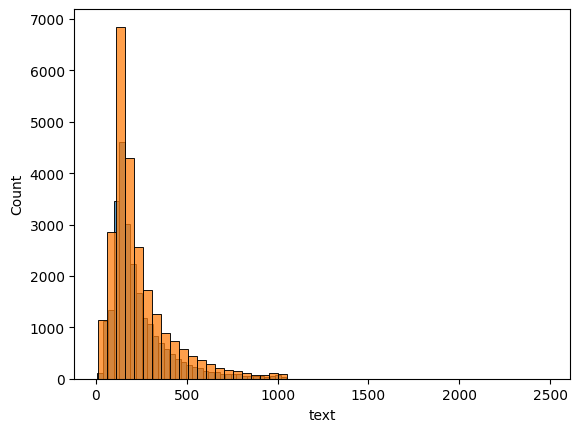

In [9]:
for label in (0, 1):
  sns.histplot(df[df['label'] == label]['text'].apply(lambda x: len(x.split(' '))), bins=50)

print(df['text'].apply(lambda x: len(x.split(' '))).mean(), df['text'].apply(lambda x: len(x.split(' '))).std())

как видим, распределение длины текста практически не зависит от его отношения к негативному или позитивному лейбл. также видно, что в среднее значения длины текста равняется 234, а стандартное отклонение равно 173. таким образом, в качестве длины вектора в будущем будеи использовать 300.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   text    50000 non-null  object
 2   rating  50000 non-null  int64 
 3   label   50000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.9+ MB


переведем значения рейтингов в последовательное ранжирование от 0 до 7

In [ ]:
df['rating'] = df['rating'].apply(lambda x: x - 1 if x < 5 else x - 3)

сохраним датасеты на гугл диск, чтобы позже с ними работать

In [ ]:
path_dir_to_save = '/content/drive/MyDrive/greenatom_test_task/'

In [ ]:
# df_train.to_csv(path_dir_to_save + 'train', index=False, quoting=3,
#                 quotechar='', escapechar='\\', encoding='utf-8')
# df_test.to_csv(path_dir_to_save + 'test', index=False, quoting=3,
#                 quotechar='', escapechar='\\', encoding='utf-8')

df.to_csv(path_dir_to_save + 'train_test', index=False, quoting=3,
         quotechar='', escapechar='\\', encoding='utf-8')

# dataset import

In [2]:
path_dir_to_save = '/content/drive/MyDrive/greenatom_test_task/'

In [10]:
# df_train = pd.read_csv(path_dir_to_save + 'train')
df_test = pd.read_csv(path_dir_to_save + 'test')

df = pd.read_csv(path_dir_to_save + 'train_test')

# data split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['rating'].values, random_state=42, test_size=0.2)

# ml approach

## count vectorizer and tf-idf

воспользуемся bag of words методами для векторизации текста

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords.words("english"),
                             max_features = 5000)

In [ ]:
tf = TfidfVectorizer(
    stop_words = stopwords.words('english'),
    max_features=5000)

## logistic regression baseline acc = 0.42

In [ ]:
for transformer in (vectorizer, tf):
  X_train_features = transformer.fit_transform(X_train)
  model = LogisticRegression(n_jobs=-1).fit(X_train_features, y_train)
  y_pred = model.predict(transformer.transform(X_test))
  print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.65      0.60      1998
           2       0.21      0.17      0.18       907
           3       0.23      0.20      0.21      1018
           4       0.27      0.27      0.27      1022
           7       0.27      0.25      0.26       958
           8       0.24      0.24      0.24      1195
           9       0.21      0.17      0.19       931
          10       0.51      0.59      0.55      1971

    accuracy                           0.38     10000
   macro avg       0.31      0.32      0.31     10000
weighted avg       0.36      0.38      0.37     10000

              precision    recall  f1-score   support

           1       0.55      0.78      0.64      1998
           2       0.21      0.08      0.12       907
           3       0.25      0.17      0.20      1018
           4       0.32      0.30      0.31      1022
           7       0.31      0.24      0.27       958
           8       0.28 

## random forest acc = 0.38

In [ ]:
for transformer in (vectorizer, tf):
  X_train_features = transformer.fit_transform(X_train)
  model = RandomForestClassifier(n_jobs=-1).fit(X_train_features, y_train)
  y_pred = model.predict(transformer.transform(X_test))
  print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.41      0.88      0.56      1998
           2       0.36      0.03      0.05       907
           3       0.31      0.03      0.06      1018
           4       0.25      0.08      0.12      1022
           7       0.33      0.08      0.12       958
           8       0.28      0.10      0.15      1195
           9       0.33      0.02      0.04       931
          10       0.37      0.84      0.52      1971

    accuracy                           0.38     10000
   macro avg       0.33      0.26      0.20     10000
weighted avg       0.34      0.38      0.27     10000

              precision    recall  f1-score   support

           1       0.41      0.88      0.56      1998
           2       0.53      0.02      0.03       907
           3       0.33      0.04      0.07      1018
           4       0.29      0.11      0.16      1022
           7       0.32      0.07      0.12       958
           8       0.25 

# DL approach

## w2w + mlp acc = 0.43

### w2v train

напишем класс для оценки и логирования работы w2v модели в течение обучения

In [ ]:
class LossLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

def on_epoch_end(self, model):
    print(f'Epoch {self.epoch}')
    self.epoch += 1

In [ ]:
train_text, test_text, y_train, y_test = train_test_split(df['text'], df['rating'], random_state=42, test_size=0.2)

In [ ]:
sentences = train_text.progress_apply(lambda x: word_tokenize(x.lower())).tolist()

  0%|          | 0/40000 [00:00<?, ?it/s]

In [ ]:
w2v_model = Word2Vec(window=7, vector_size=256, min_count=10, shrink_windows=True, seed=42, alpha=0.05)
w2v_model.build_vocab(sentences)

обучим модель на 35 эпохах

In [ ]:
w2v_model.train(
    corpus_iterable=sentences,
    total_examples=w2v_model.corpus_count,
    epochs=35,
    compute_loss=True,
    callbacks=[LossLogger()]
    )

Loss after epoch 0: 5127554.5
Loss after epoch 1: 4507081.5
Loss after epoch 2: 4131001.0
Loss after epoch 3: 4030459.0
Loss after epoch 4: 3628400.0
Loss after epoch 5: 3544828.0
Loss after epoch 6: 3572418.0
Loss after epoch 7: 3606156.0
Loss after epoch 8: 2940342.0
Loss after epoch 9: 2450752.0
Loss after epoch 10: 2439476.0
Loss after epoch 11: 2431576.0
Loss after epoch 12: 2399984.0
Loss after epoch 13: 2261252.0
Loss after epoch 14: 2279972.0
Loss after epoch 15: 2298000.0
Loss after epoch 16: 2279504.0
Loss after epoch 17: 2203808.0
Loss after epoch 18: 2200544.0
Loss after epoch 19: 2116388.0
Loss after epoch 20: 1998020.0
Loss after epoch 21: 1942128.0
Loss after epoch 22: 1928536.0
Loss after epoch 23: 979900.0
Loss after epoch 24: 321088.0
Loss after epoch 25: 298584.0
Loss after epoch 26: 280040.0
Loss after epoch 27: 257096.0
Loss after epoch 28: 243328.0
Loss after epoch 29: 228464.0
Loss after epoch 30: 201176.0
Loss after epoch 31: 191912.0
Loss after epoch 32: 170752

(239585449, 327633425)

In [ ]:
w2v_model.save(path_dir_to_save + 'w2v.model')

### w2v model load

In [ ]:
w2v_model = Word2Vec.load(path_dir_to_save + 'w2v.model')

### w2v vectorize

напишем класс для векторизации текстов посредством усреднения вектора и заполнения нулями при встрече незнакомых символов

In [ ]:
class Word2VecTransformer:

    def __init__(self, w2v_model1, w2v_model2='', word_pattern=''):

        self.w2v_model1 = w2v_model1
        self.w2v_model2 = w2v_model2
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):
        mmean = 0
        X_transformed = np.zeros((len(X), self.w2v_model1.wv.vector_size))
        for i, title in enumerate(X):
            count = 0
            title_vector_avg = np.zeros((self.w2v_model1.wv.vector_size,))
            tokens = self.re.findall(title.lower())
            for token in tokens:
                if token in self.w2v_model1.wv.key_to_index:
                    title_vector_avg += self.w2v_model1.wv.get_vector(token)
                    count += 1
            if count:
                mmean += title_vector_avg / count
        for i, title in enumerate(X):
            count = 0
            title_vector_avg = np.zeros((self.w2v_model1.wv.vector_size,))
            tokens = self.re.findall(title.lower())
            for token in tokens:
                if token in self.w2v_model1.wv.key_to_index:
                    title_vector_avg += self.w2v_model1.wv.get_vector(token)
                    count += 1
            if count:
                X_transformed[i] = title_vector_avg / count
            else:
                X_transformed[i][...] = mmean
        return X_transformed

In [ ]:
WORD_PATTERN = '(?u)\\b\\w\\w+\\b'

w2v_transformer = Word2VecTransformer(w2v_model1=w2v_model, word_pattern=WORD_PATTERN)

In [ ]:
X_test = w2v_transformer.transform(test_text)
X_train = w2v_transformer.transform(train_text)

### mlp training

исползуем базовую модель перцептрон для обучения на векторах

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 16),
                        max_iter = 100,
                        activation = 'relu',
                        learning_rate='adaptive',
                        alpha=0.25, n_iter_no_change=15,
                        solver = 'adam', verbose=True, early_stopping=True, random_state=42)

In [ ]:
mlp.fit(
    X=X_train,
    y=y_train)

Iteration 1, loss = 1.76859578
Validation score: 0.416750
Iteration 2, loss = 1.56501494
Validation score: 0.422750
Iteration 3, loss = 1.53277761
Validation score: 0.429500
Iteration 4, loss = 1.51521767
Validation score: 0.417000
Iteration 5, loss = 1.50181930
Validation score: 0.431500
Iteration 6, loss = 1.49281984
Validation score: 0.430000
Iteration 7, loss = 1.48182624
Validation score: 0.432750
Iteration 8, loss = 1.47897539
Validation score: 0.427000
Iteration 9, loss = 1.47148223
Validation score: 0.431250
Iteration 10, loss = 1.46595382
Validation score: 0.424500
Iteration 11, loss = 1.46109559
Validation score: 0.434500
Iteration 12, loss = 1.45719534
Validation score: 0.433250
Iteration 13, loss = 1.45291624
Validation score: 0.434250
Iteration 14, loss = 1.45447592
Validation score: 0.427000
Iteration 15, loss = 1.44845378
Validation score: 0.427000
Iteration 16, loss = 1.44362725
Validation score: 0.430500
Iteration 17, loss = 1.44018711
Validation score: 0.431500
Iterat

MLPClassifier(alpha=0.25, early_stopping=True, hidden_layer_sizes=(128, 64, 16),
              learning_rate='adaptive', max_iter=100, n_iter_no_change=15,
              random_state=42, verbose=True)

In [ ]:
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.53      0.83      0.64      1998
           2       0.50      0.00      0.00       907
           3       0.27      0.17      0.21      1018
           4       0.33      0.35      0.34      1022
           7       0.34      0.23      0.28       958
           8       0.31      0.23      0.26      1195
           9       0.00      0.00      0.00       931
          10       0.46      0.83      0.59      1971

    accuracy                           0.43     10000
   macro avg       0.34      0.33      0.29     10000
weighted avg       0.37      0.43      0.36     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## w2v + lstm

In [ ]:
from IPython.display import clear_output


def plot_progress(train_losses, val_loss, train_accs, val_accs, lrs):
    clear_output(True)

    f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    f.set_figheight(6)
    f.set_figwidth(16)

    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss', fontsize=14)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()

    ax2.plot(train_accs, label='Train Auc')
    ax2.plot(val_accs, label='Val Auc')
    ax2.plot(np.ones_like(train_accs), '--', label='Accuracy')
    ax2.set_title('Auc', fontsize=14)
    ax2.set_ylabel('Auc')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    ax3.plot(lrs, label='learning rate')
    ax3.set_title('Learing rate')
    ax3.set_xlabel('Batch number')
    ax3.legend()

    plt.show()

In [ ]:
def calculate_metric_val_dataset(model, val_sequence_dataloader):
    scores = []
    cats = []
    y_true = []
    for (x, y, cat) in val_sequence_dataloader:
        with torch.no_grad():
            y_true.extend(y)
            cats.extend(cat.numpy())
            x = x.to(DEVICE)
            preds = model(x).detach().cpu()
            scores.extend(preds)
    return calculate_metric(y_true, scores, cats)

In [3]:
class LSTMWithAttention(nn.Module):
    def __init__(
        self,
        #vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers=1,
        use_bidirectional = False,
        dropout: float = 0.0,
        hidden_fc_size: int = 128
    ):
        super().__init__()
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(256,
                           hidden_dim // 2,
                           batch_first=True,
                           bidirectional=use_bidirectional,
                           dropout=dropout)
        self.linear1 = nn.Linear(hidden_dim, 32)
        self.linear2 = nn.Linear(32, 1)
        self.after_linear = nn.Sequential(
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.linear2.weight.data.normal_(0, (2 / 32) ** 0.5)
        self.linear1.weight.data.normal_(0, (2 / 256) ** 0.5)

    def attention(self, lstm_output, final_state):
        merged_state = torch.cat([s for s in final_state], 1)
        merged_state = merged_state.unsqueeze(2)
        weights = torch.bmm(lstm_output, merged_state)
        weights = F.softmax(weights.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(lstm_output, 1, 2), weights).squeeze(2)

    def forward(self, x):
        #embedded = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)

        attn_output = self.attention(output, hidden)
        x = self.after_linear(self.linear1(attn_output.squeeze(0)))
        return self.sigmoid(self.linear2(x)).squeeze()

# BERT fine-tuning

### base-line (max_len=128, bert = 'bhadresh-savani/bert-base-uncased-emotion') f1=0.44

In [36]:
bert = "google-bert/bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(bert)
model_bert = BertForSequenceClassification.from_pretrained(bert, num_labels=len(df['rating'].unique()), ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
train_text, test_text, y_train, y_test = train_test_split(df['text'], df['rating'], random_state=42, test_size=0.2, stratify=df['rating'])

In [17]:
MAX_LEN = 256

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation='only_first', max_len=MAX_LEN)

X_train = tokenizer(train_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)
X_test = tokenizer(test_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)

#### custom dataset

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = CustomDataset(X_train, y_train.to_list())
test_dataset = CustomDataset(X_test, y_test.to_list())

#### metric

In [20]:
def compute_f1_accuracy(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    labels_cpu = torch.tensor(labels).cpu().numpy()
    preds_cpu = torch.tensor(preds).cpu().numpy()

    f1 = f1_score(labels_cpu, preds_cpu, average='weighted')
    accuracy = accuracy_score(labels_cpu, preds_cpu)
    return {'f1': f1, 'accuracy': accuracy}

#### train

In [21]:
training_args = TrainingArguments(
    output_dir=path_dir_to_save + 'model_3_results',
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy='steps',
    eval_steps=500,
    save_total_limit=2,
    save_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_f1_accuracy
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1,Accuracy
500,1.611000,1.418773,0.357384,0.453600
1000,1.397100,1.403151,0.385016,0.442000
1500,1.294200,1.357437,0.411840,0.465000
2000,1.209800,1.311168,0.421115,0.477400
2500,1.192800,1.289059,0.436849,0.480300
3000,0.987900,1.429435,0.449446,0.456600


In [ ]:
import pickle

with open('bert_model.pkl', 'wb') as model_file:
    pickle.dump(model_bert, model_file)

with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

#### model loading

In [7]:
with open(path_dir_to_save + 'bert_model.pkl', 'rb') as model_file:
    bert_model = pickle.load(model_file)


with open(path_dir_to_save + 'tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


#### model eveluation

In [18]:
def predict_texts(bert_model, tokenizer, texts, device='cpu'):
    # Переводим модель в режим оценки
    bert_model.eval()

    # Список для хранения предсказаний
    predictions = []
    labels = []

    # Обрабатываем каждый текст
    with torch.no_grad():
        for text in tqdm_notebook(texts):
            # Токенизация текста
            inputs = tokenizer(text, return_tensors='pt', padding=True, truncation='only_first', max_length=256)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Получаем предсказания от модели
            outputs = bert_model(**inputs)
            logits = outputs.logits  # Предполагается, что последний слой модели возвращает logits

            # Применяем softmax для получения вероятностей
            probabilities = torch.softmax(logits, dim=1)

            # Получаем индекс класса с наивысшей вероятностью
            predicted_class = torch.argmax(probabilities, dim=1).item()

            if predicted_class <= 3:
                predicted_class += 1
                label = 0
            else:
                predicted_class += 3
                label = 1

            # Добавляем предсказание в список
            predictions.append(predicted_class)
            labels.append(label)

    return predictions, labels

In [20]:
rating_pred, labels_pred = predict_texts(bert_model,
              tokenizer,
              df_test.text.to_list()[:1000])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
rating_true = df_test.rating[:1000]
labels_true = df_test.label[:1000]

print('mae:', mean_absolute_error(rating_true, rating_pred))
print('f1:', f1_score(rating_true, rating_pred, average='weighted'))
print('accuracy:', accuracy_score(labels_true, labels_pred))

mae: 0.559
f1: 0.6087717704956944
accuracy: 0.976


#### model saving

In [ ]:
torch.save(model_bert.state_dict(), path_dir_to_save + 'model_bert')
tokenizer.save(path_dir_to_save + 'tokenizer')

### bert 2 f1 = 0.43

In [5]:
bert = "google-bert/bert-base-uncased"

tokenizer = BertTokenizer.from_pretrained(bert)
model_bert = BertForSequenceClassification.from_pretrained(bert, num_labels=len(df['rating'].unique()), ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_text, test_text, y_train, y_test = train_test_split(df['text'], df['rating'], random_state=42, test_size=0.2, stratify=df['rating'])

In [ ]:
MAX_LEN = 300

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation='only_first', max_len=MAX_LEN)

X_train = tokenizer(train_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)
X_test = tokenizer(test_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)

In [ ]:
train_dataset = CustomDataset(X_train, y_train.to_list())
test_dataset = CustomDataset(X_test, y_test.to_list())

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',
    eval_steps=500,
    save_total_limit=2,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)


trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_f1_accuracy,
)

trainer.create_optimizer_and_scheduler(num_training_steps=len(train_dataset.labels) // training_args.per_device_train_batch_size * training_args.num_train_epochs)


optimizer = trainer.optimizer
num_training_steps = training_args.num_train_epochs * len(test_dataset.labels) // training_args.per_device_train_batch_size
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1
500,1.615200,1.376326,0.348599
1000,1.382900,1.398479,0.378502
1500,1.278300,1.317840,0.427108
2000,1.189400,1.296966,0.436460
2500,1.173800,1.283805,0.437272


In [ ]:
torch.save(model_bert, path_dir_to_save + 'model_bert_2')

## bert 3

In [90]:
bert = 'bert-base-uncased'

tokenizer_3 = BertTokenizer.from_pretrained(bert)
model_bert_3 = BertForSequenceClassification.from_pretrained(bert, num_labels=len(df['rating'].unique()), ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


заморозка половины весов

In [69]:
train_text, test_text, y_train, y_test = train_test_split(df['text'], df['rating'], random_state=42, test_size=0.1, stratify=df['rating'])

In [70]:
MAX_LEN = 300

X_train = tokenizer_3(train_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)
X_test = tokenizer_3(test_text.tolist(), truncation='only_first', padding=True, max_length=MAX_LEN)

In [71]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [73]:
train_dataset = CustomDataset(X_train, y_train.to_list())
test_dataset = CustomDataset(X_test, y_test.to_list())

In [91]:
training_args = TrainingArguments(
    output_dir=path_dir_to_save + 'model_3_results',
    num_train_epochs=4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy='steps',
    eval_steps=500,
    save_total_limit=2,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)

num_training_steps = training_args.num_train_epochs * len(test_dataset.labels) // training_args.per_device_train_batch_size

optimizer = AdamW(model_bert_3.parameters(), lr=5e-3)

scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=num_training_steps,
    num_cycles=1
)

trainer = Trainer(
    model=model_bert_3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_f1_accuracy,
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [92]:
trainer.train()

Step,Training Loss,Validation Loss,F1,Accuracy
500,2.070500,2.028819,0.063401,0.194600
1000,2.027300,2.026804,0.068140,0.202400


KeyboardInterrupt: 

In [ ]:
torch.save(model_bert_3, path_dir_to_save + 'model_bert_3')
torch.save(tokenizer_3, path_dir_to_save + 'tokenizer_3')